In [1]:
def print_pixel_over_ROI(x,y,w,h,image_gray):
    
    # Iterate over each pixel in the image
    for row in range(y,y+h):
        for col in range(x,x+w):
            # Access the pixel value at the current position
            pixel = image_gray[row, col]

            # Print the pixel value
            print('Pixel at ({}, {}): {}'.format(row, col, pixel))
        

In [2]:
import cv2
import numpy as np
import os

def extract_middle_roi(image, target_width):
    # Get the original image dimensions
    height, width = image.shape[:2]

    # Calculate the aspect ratio
    aspect_ratio = width / height

    # Calculate the target height based on the aspect ratio
    target_height = int(target_width / aspect_ratio)

    # Calculate the coordinates of the top-left and bottom-right corners of the middle region
    x = int((width - target_width) / 2)
    y = int((height - target_height) / 2)
    x2 = x + target_width
    y2 = y + target_height

    # Extract the middle region
    middle_roi = image[y:y2, x:x2]

    return middle_roi

def filter_contours(contours, binary_image, ratio, ratio2=None):
    # Create a copy of the original image
    image_with_rectangles = np.copy(binary_image)
    
    #ratio is a list with first element as lower bound and second element as upper bound
    aspect_ratios = []
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (255), 1)  # Adjust color and thickness as needed
        
        aspect_ratio = float(w) / h
        if not ratio2:
            if aspect_ratio >= ratio[0] and aspect_ratio <= ratio[1]:
                filtered_contours.append(contour)
        else:
            if (aspect_ratio >= ratio[0] and aspect_ratio <= ratio[1]) or (aspect_ratio >= ratio2[0] and aspect_ratio <= ratio2[1]):
                filtered_contours.append(contour)
                
    #Check the images with bounding rectangles
    cv2.imwrite("bounding_rect.jpg", image_with_rectangles)
    
    # Create a mask of the filtered contours
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, filtered_contours, -1, (255), thickness=cv2.FILLED)
    return mask

def preprocess_image(image_path, threshold_val=0):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crop image
    image = extract_middle_roi(image, 1500)

    if threshold_val == 0:
        threshold_val = 5
        # Find threshold with sd
        for x in range(5, 10):
            mask = np.where(image < x, 1, 0)
            masked_intensities = image[mask == 1]
            mean_intensity = np.mean(masked_intensities)
            sd_intensity = np.std(masked_intensities)
            two_sd = (mean_intensity + (2 * sd_intensity))
            three_sd = (mean_intensity + (3 * sd_intensity))
            print("current threshold: {}".format(x))
            print("two_sd: {}".format(two_sd))
            print("three_sd: {}".format(three_sd))

            if x >= two_sd and x <= three_sd:
                threshold_val = x
                break

    # Filter out pixels with intensities below the threshold_val
    threshold_val, image_filtered = cv2.threshold(image, threshold_val, 255, cv2.THRESH_TOZERO)

    print("Threshold value:", threshold_val)

    # Save and download to local disk
    # Extract the filename from the original image path
    filename = image_path.split("/")[-1]

    # Create the new path by concatenating the desired directory and the filename
    new_path = os.path.dirname(image_path) + "/thresholded/"

    # Create the folder if it doesn't exist
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    new_path += filename

    cv2.imwrite(new_path, image_filtered)

    print("Saved thresholded image to: {}".format(new_path))

    return threshold_val


In [3]:
#test preprocessing
preprocess_image("/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/4_8_8_Z_110000000.bmp")

current threshold: 5
two_sd: 2.9133315310564813
three_sd: 3.6667734081661303
current threshold: 6
two_sd: 3.3106498591069915
three_sd: 4.223251374059595
current threshold: 7
two_sd: 3.697777137351943
three_sd: 4.767387507793027
current threshold: 8
two_sd: 4.070212752864464
three_sd: 5.29222291648992
current threshold: 9
two_sd: 4.4568269625609105
three_sd: 5.838017936534875
Threshold value: 5.0
Saved thresholded image to: /mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/4_8_8_Z_110000000.bmp


5.0

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_max_intensity_location(image_name):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize variables to track the highest intensity and its location
    max_intensity = 0
    max_intensity_location = None

    # Iterate over each pixel in the image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            intensity = image[x,y]

            # Update the highest intensity and its location if a higher intensity is found
            if intensity > max_intensity and intensity < 255:
                max_intensity = intensity
                max_intensity_location = (x,y)
    
    # Print the highest intensity pixel
    print("Highest intensity:", max_intensity)
    
    # Print the location of the highest intensity pixel
    print("Highest intensity location:", max_intensity_location)
    return max_intensity_location



In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

def plot_intensity_vs_x(image_name, x, fixed_y):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    x_coordinates = []
    intensities = []

    # Iterate over each pixel in the image
    for x in range(x - 40, x + 40):
        intensity = image[fixed_y, x]
        x_coordinates.append(x)
        intensities.append(intensity)
        if intensity > 225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)

    # Plot the graph
    plt.scatter(x_coordinates, intensities)
    plt.xlabel('X Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs X Coordinate')

    plot_path = os.path.dirname(image_name) + "/plots/"

    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_x.jpg")

    plt.show()

def plot_intensity_vs_y(image_name, fixed_x, y):
    # Load the grayscale image
    image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Initialize lists to store the x-axis coordinates and y-axis intensities
    y_coordinates = []
    intensities = []

    # Iterate over each pixel in the image
    for y in range(y - 40, y + 40):
        intensity = image[y, fixed_x]
        y_coordinates.append(y)
        intensities.append(intensity)
        if intensity > 225:
            with open(os.path.dirname(image_name) + 'logfile.txt', "a") as f:
                print("{} is overexposed.".format(image_name), file=f)

    # Plot the graph
    plt.scatter(y_coordinates, intensities)
    plt.xlabel('Y Coordinates')
    plt.ylabel('Pixel Intensity')
    plt.title('Intensity vs Y Coordinate')

    plot_path = os.path.dirname(image_name) + "/plots/"

    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    plt.savefig(os.path.dirname(image_name) + "/plots/" + os.path.basename(image_name) + "_vs_y.jpg")

    plt.show()
    
# Calculate the average number of white pixels in each contour
def get_contour_average_white_pixels(image_path, threshold):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    
    cv2.imwrite("binary_image.jpg", binary_image)
    
    # Find contours in the image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_white_pixels = 0
    total_white_pixels_arr = []
    total_contours = 0
    
    for contour in contours:
        white_pixels = cv2.contourArea(contour)
        if white_pixels>=10:
            total_white_pixels += white_pixels
            total_white_pixels_arr.append(white_pixels)
            total_contours += 1
            
    # Sample data for the scatter plot
    x_values = [x for x in range(len(total_white_pixels_arr))]
    
    print(len(x_values))
    print(len(total_white_pixels_arr))
    
    # Create the scatter plot
    plt.scatter(x_values, total_white_pixels_arr)

    # Add labels and title
    plt.xlabel("X-axis label")
    plt.ylabel("Y-axis label")
    plt.title("Scatter Plot Example")

    # Show the plot
    plt.show()
    
    average_white_pixels = total_white_pixels / total_contours

    print("Average number of white pixels in each contour:", average_white_pixels)
    
    
def find_contour_closest_to_pixel(image_path, target_pixel_location):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Find contours in the image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the centroid of the target pixel location
    target_centroid = np.array(target_pixel_location)
    
    closest_contour = None
    closest_contour_centroid = None
    min_distance = float('inf')
    
    for contour in contours:
        # Calculate the centroid of the current contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            centroid_x = int(M["m10"] / M["m00"])
            centroid_y = int(M["m01"] / M["m00"])
            centroid = np.array((centroid_x, centroid_y))

            # Calculate the Euclidean distance between the target pixel and the contour centroid
            distance = np.linalg.norm(target_centroid - centroid)

            # Update the closest contour if a smaller distance is found
            if distance < min_distance:
                closest_contour = contour
                min_distance = distance
                closest_contour_centroid = centroid

    x, y, w, h = cv2.boundingRect(closest_contour)

    # Draw the bounding rectangle on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (255), 2)
    
    # Draw the circle on the center of the contour
    cv2.circle(image, (closest_contour_centroid[0], closest_contour_centroid[1]), 3, (255), -1)
                
    print("Save test image")
    plot_path = os.path.dirname(image_path) + "/test_image/"

    # Create the folder if it doesn't exist
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)

    # Save the image using OpenCV's imwrite()
    cv2.imwrite(os.path.join(plot_path, os.path.basename(image_path) + ".jpg"), image)
        
    return closest_contour, closest_contour_centroid

# Example usage
# target_pixel_location = (100, 200)  # Replace with the coordinates of your target pixel
# contour = find_contour_with_pixel("path/to/your/image.jpg", target_pixel_location)
# if contour is not None:
#     print("Contour found!")
# else:
#     print("No contour found containing the target pixel.")



total white pixels in this contour: 12.0
total white pixels in this contour: 25.0
total white pixels in this contour: 72.0
total white pixels in this contour: 54.0
total white pixels in this contour: 61.5
total white pixels in this contour: 92.5
total white pixels in this contour: 105.5
total white pixels in this contour: 133.0
total white pixels in this contour: 148.0
total white pixels in this contour: 178.0
total white pixels in this contour: 181.0
total white pixels in this contour: 204.0
total white pixels in this contour: 217.0
total white pixels in this contour: 236.5
total white pixels in this contour: 252.0
total white pixels in this contour: 267.5
total white pixels in this contour: 278.5
total white pixels in this contour: 326.0
total white pixels in this contour: 343.0
total white pixels in this contour: 370.0
total white pixels in this contour: 353.5
total white pixels in this contour: 388.5
total white pixels in this contour: 353.5
total white pixels in this contour: 340.

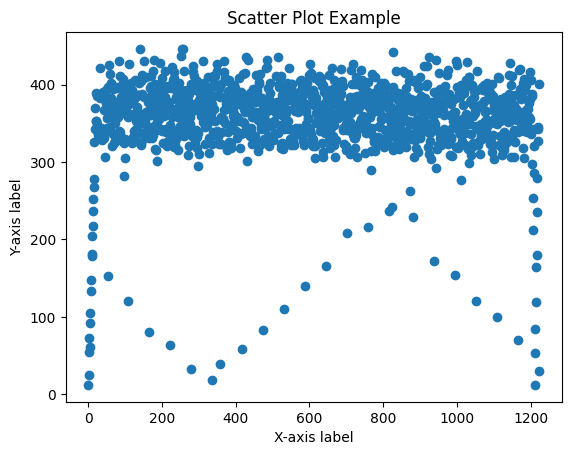

Average number of white pixels in each contour: 354.96609477124184


In [33]:
get_contour_average_white_pixels("/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/blue_data/thresholded/4_8_8_Z_110000000.bmp", 5)

In [ ]:
# directory should include all images one wishes to process
directory = "/mnt/c/Users/alada/JC_Electronics/JC-SDKIntegration/red_data_0.1/"

image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]

# Preprocess images to filter out RGB
threshold_val = 0
for image_file in image_files:
    if threshold_val == 0:
        threshold_val = preprocess_image(image_file)
    else:
        preprocess_image(image_file, threshold_val=threshold_val)

# Read in images from corresponding directory
directory = directory + "thresholded/"
    
x = 0
y = 0
image_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg", ".png", ".bmp"))]
for image_file in image_files:
    print(image_file)
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # Construct scatter plot of pixel intensities
    # Get the dimensions of the image
    height, width = image.shape[:2]

    if x == 0 or y == 0:
        # Find the middle coordinates
        middle_x = height // 2
        middle_y = width // 2
        contour, centroid = find_contour_closest_to_pixel(image_file, (middle_y,middle_x))
        
        x,y = centroid

    print("Centroid: {}".format(centroid))

    plot_intensity_vs_x(image_file, x, y)
    plot_intensity_vs_y(image_file, x, y)


In [ ]:
#check whether two grayscale images are identical
    
import cv2
import numpy as np

def display_nonzero_numbers(array, max_count=100):
    # Get the indices of the nonzero elements
    indices = np.nonzero(array)

    # Extract the values at the nonzero indices
    values = array[indices]

    # Display up to the specified number of nonzero values
    count = min(max_count, len(values))
    for i in range(count):
        index = tuple(idx[i] for idx in indices)
        value = values[i]
        print(f"Value at index {index}: {value}")
        
def are_images_identical(image1, image2):
    # Compare the dimensions of the images
    if image1.shape != image2.shape:
        return False

    # Compare each pixel of the images
    difference = cv2.subtract(image1, image2)
    
    # Check if all pixels are zero (indicating identical images)
    display_nonzero_numbers(difference)
    return cv2.countNonZero(difference) == 0

# Load the grayscale images
image1 = cv2.imread("32_32_32_clear_3600000.bmp", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("camera_32_32_32.bmp", cv2.IMREAD_GRAYSCALE)

are_images_identical(image1, image2)


In [ ]:
# try different threshold, and save these images
import cv2 
import numpy as np
import csv

# Read image in grayscale
image_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/Red32/32_32_32_clear_4000.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = extract_middle_roi(image, 1500)

# Initialize a list to store the results
results = []

for threshold in range(5, 50):
    _, filtered_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    new_path = "/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/threshold=" + str(threshold) + ".bmp"
#     cv2.imwrite(new_path, filtered_image)
    
    # for each image, find the average, sd, and average + sd, and export them to a csv file
    
    # Perform calculations for black pixels
    black_mask = np.where(image < threshold, 1, 0)
    black_masked_intensities = image[black_mask == 1]
    black_mean_intensity = np.mean(black_masked_intensities)
    black_sd_intensity = np.std(black_masked_intensities)
    black_one_sd = black_mean_intensity + (1 * black_sd_intensity)
    black_two_sd = black_mean_intensity + (2 * black_sd_intensity)
    
    # Perform calculations for white pixels
    white_mask = np.where(image >= threshold, 1, 0)
    white_masked_intensities = image[white_mask == 1]
    white_mean_intensity = np.mean(white_masked_intensities)
    white_sd_intensity = np.std(white_masked_intensities)
    white_one_sd = white_mean_intensity + (1 * white_sd_intensity)
    white_two_sd = white_mean_intensity + (2 * white_sd_intensity)
    
    # Store the results in a dictionary
    result = {
        'Threshold': threshold,
        'Mean Intensity of Black Pixels': black_mean_intensity,
        'Standard Deviation of Black Pixels': black_sd_intensity,
        'Black One SD Above Average': black_one_sd,
        'Black Two SD Above Average': black_two_sd,
        'Mean Intensity of White Pixels': white_mean_intensity,
        'Standard Deviation of White Pixels': white_sd_intensity,
        'White One SD Above Average': white_one_sd,
        'White Two SD Above Average': white_two_sd
    }
    results.append(result)
    
# Define the CSV file path
csv_file_path = '/mnt/c/Users/alada/JC_Code/JC-SDKIntegration/ThresholdExperiment/results.csv'

# Define the fieldnames for the CSV file
fieldnames = [
    'Threshold',
    'Mean Intensity of Black Pixels',
    'Standard Deviation of Black Pixels',
    'Black One SD Above Average',
    'Black Two SD Above Average',
    'Mean Intensity of White Pixels',
    'Standard Deviation of White Pixels',
    'White One SD Above Average',
    'White Two SD Above Average'
]

# Write the results to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for result in results:
        writer.writerow(result)


# Print a confirmation message
print("Results exported to results.csv")